# CNN
필터를 일부 특성에 적용해 중요한 특성을 추출하는 알고리즘
- 필터 : 밀집층의 뉴런 역할과 같은 역할
- 커널 : 필터의 가중치와 절편
---

[구성]
- 합성곱층
  - same padding을 통해 입력과 동일 크기로 특성맵을 만든다.
- 풀링층
  - 합성곱 층의 출력값인 특성맵을 최대풀링 혹은 평균 풀링을 통해 크기를 줄인다.
  - 이때, 특성맵 개수는 동일하다.

### load Data

data : fasion MNIST data

keras에 내장된 데이터는 자동으로 train, test가 split되어 반환한다.

In [1]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = \
              keras.datasets.fashion_mnist.load_data()
print(train_input.shape, test_input.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


### Data Preparation

합성곱층의 input data는 3차원(가로,세로,깊이)이므로 깊이 층을 추가한다.

In [2]:
from sklearn.model_selection import train_test_split

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [3]:
print(train_scaled.shape)

(48000, 28, 28, 1)


### model construct

In [4]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                             padding='same', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D(2))

In [5]:
model.add(keras.layers.Conv2D(64, kernel_size=3, padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPooling2D(2))

In [6]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

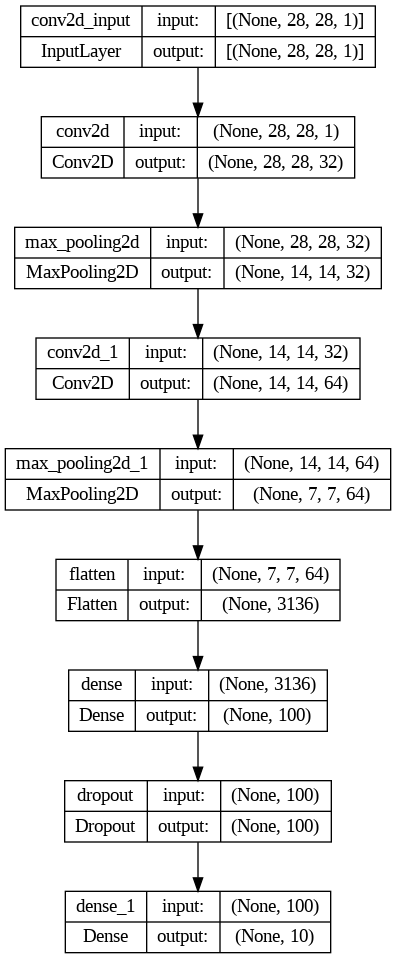

In [8]:
keras.utils.plot_model(model, show_shapes=True)

### Train

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# callback
checkpoints_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoints_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 81s 51ms/step - loss: 0.5190 - accuracy: 0.8145 - val_loss: 0.3353 - val_accuracy: 0.8745
Epoch 2/20
1500/1500 [==============================] - 77s 51ms/step - loss: 0.3493 - accuracy: 0.8752 - val_loss: 0.2907 - val_accuracy: 0.8908
Epoch 3/20
1500/1500 [==============================] - 71s 47ms/step - loss: 0.2987 - accuracy: 0.8917 - val_loss: 0.2529 - val_accuracy: 0.9043
Epoch 4/20
1500/1500 [==============================] - 70s 46ms/step - loss: 0.2681 - accuracy: 0.9029 - val_loss: 0.2497 - val_accuracy: 0.9074
Epoch 5/20
1500/1500 [==============================] - 70s 46ms/step - loss: 0.2476 - accuracy: 0.9096 - val_loss: 0.2392 - val_accuracy: 0.9122
Epoch 6/20
1500/1500 [==============================] - 76s 51ms/step - loss: 0.2263 - accuracy: 0.9170 - val_loss: 0.2331 - val_accuracy: 0.9141
Epoch 7/20
1500/1500 [==============================] - 73s 48ms/step - loss: 0.2079 - accuracy: 0.9234 - val_loss: 0.2323 -

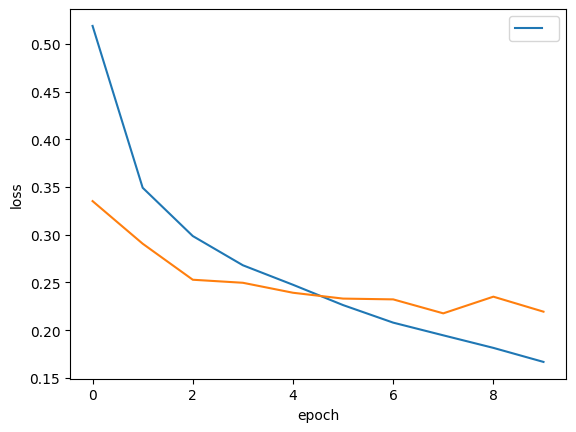

In [ ]:

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend([''])
plt.show()

In [ ]:
early_stopping_cb.best_epoch

7

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 4s 11ms/step - loss: 0.2176 - accuracy: 0.9201


[0.21764279901981354, 0.9200833439826965]

### Predict

sample data로 validation data의 첫번재 data를 사용해서 예측해보자.

In [ ]:
val_scaled.shape

(12000, 28, 28, 1)

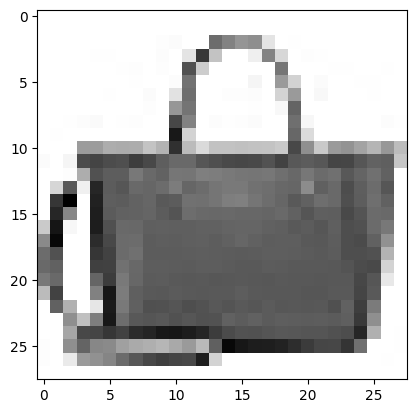

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [ ]:
print(val_scaled[0:1].shape)

pred = model.predict(val_scaled[0:1])
print(pred)

(1, 28, 28, 1)
1/1 [==============================] - 0s 145ms/step
[[1.09529000e-14 2.88383777e-19 6.36261496e-18 1.14071714e-14
  2.59821936e-15 4.45800584e-11 8.92143593e-16 2.59036698e-11
  1.00000000e+00 2.26703845e-14]]


fit(), predict(), evaluate() 메서드는 모두 첫번째 차원이 배치차원일 것으로 기대한다.
> 배치차원 : 모델이 한 번에 처리할 입력 데이터 묶음

val_scaled[0] 은 (28, 28, 1)이다.

이때, slicing을 하면 전체 차원이 유지되어 val_scaled[0:1]은 (1, 28, 28, 1)이다.

e: 지수 표현으로, e-3 == 10^3

따라서 위 predict 결과를 보면 9번째 class일 확률이 1에 가깝다는 것을 알 수 있다.

### Plot

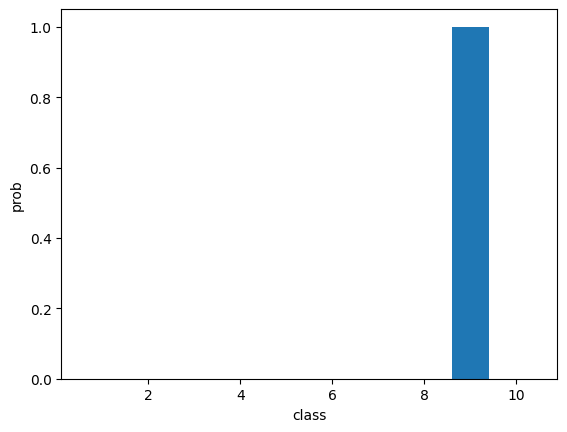

In [ ]:
plt.bar(range(1, 11), pred[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

In [ ]:
classes=['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

예측한 category 확인

In [ ]:
import numpy as np
print(classes[np.argmax(pred)])

가방


일반화 성능 평가

In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1)

model.evaluate(test_scaled, test_target)

313/313 [==============================] - 5s 16ms/step - loss: 30.8925 - accuracy: 0.8825


[30.892499923706055, 0.8824999928474426]